<a href="https://colab.research.google.com/github/GJotaJunior/Postech-IA-Fase5/blob/main/Sharp_Objects_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise de Vídeo para Detecção de Objetos Cortantes

In [12]:
%pip install opencv-python
%pip install numpy
%pip install matplotlib
%pip install openai

## Configurações das dependências

In [13]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
import os
import cv2
import json
import base64
import smtplib
import numpy as np
from google.colab import userdata
from matplotlib import pyplot as plt
from openai import OpenAI
from email import encoders
from email.mime.base import MIMEBase
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText


# Configurações do SMTP
SMTP_SERVER = userdata.get("SMTP_SERVER")
SMTP_PORT = 465
EMAIL_SENDER = userdata.get("EMAIL_SENDER")
EMAIL_PASSWORD = userdata.get("EMAIL_PASSWORD")
EMAIL_RECEIVER = userdata.get("EMAIL_RECEIVER")


# Configurações de OpenAI
client = OpenAI(
    api_key=userdata.get("OPENAI_API_KEY")
)


# Função para exibir um frame
def show_frame(frame, title=""):
    frame = base64.b64decode(frame)
    frame = cv2.imdecode(np.frombuffer(frame, np.uint8), cv2.IMREAD_COLOR)
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")
    plt.show()


## Leitura de Vídeo e Processamento de Frames

Total frames: 1264
Distinct frames: 13


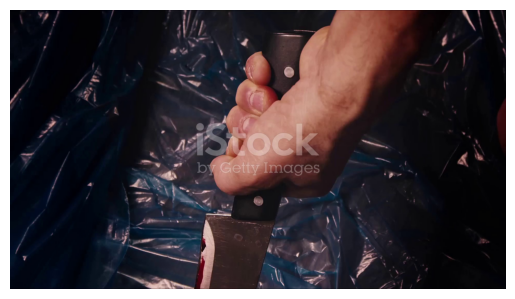

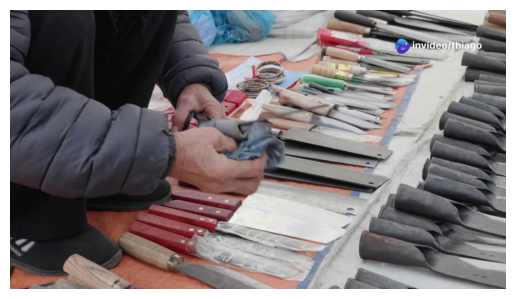

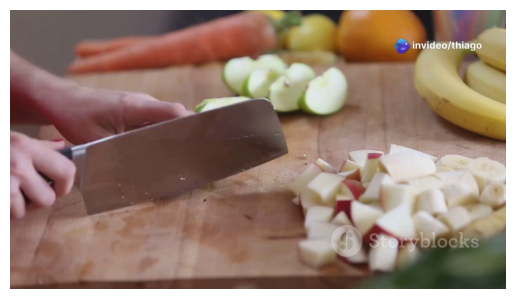

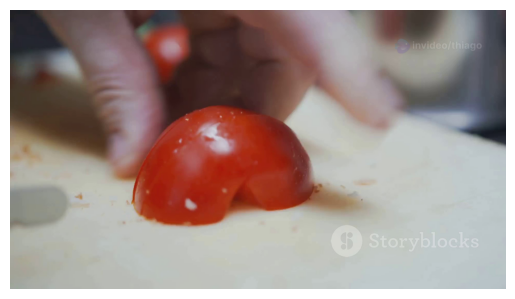

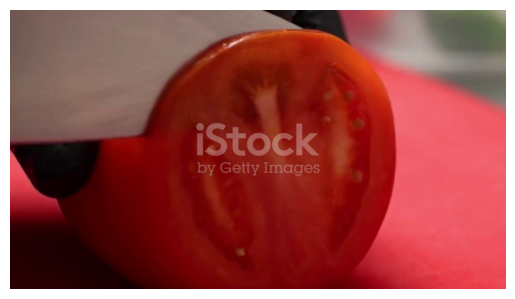

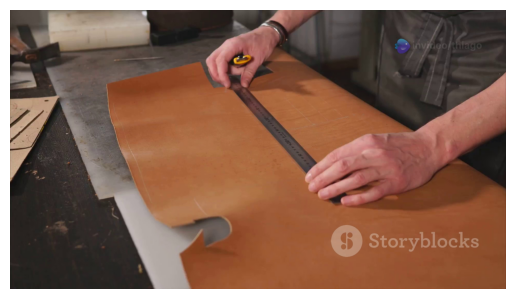

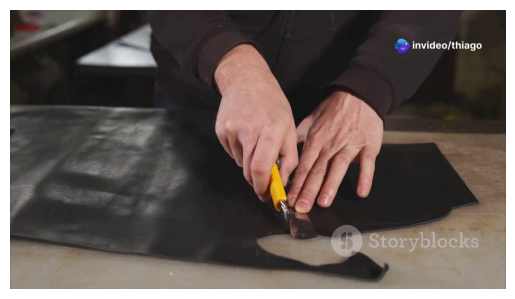

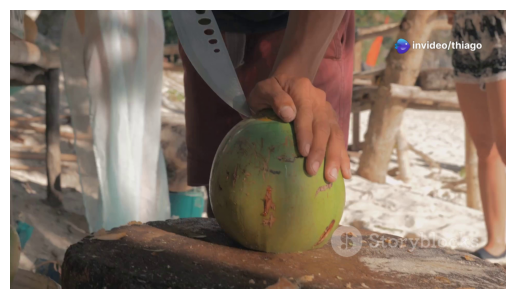

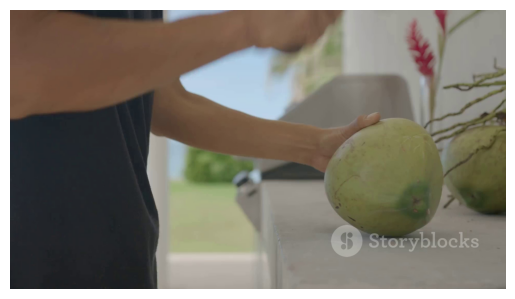

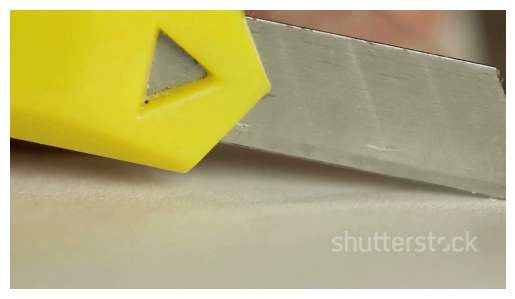

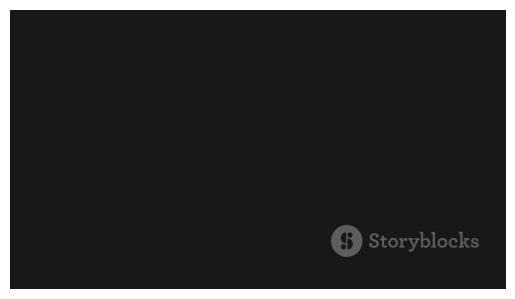

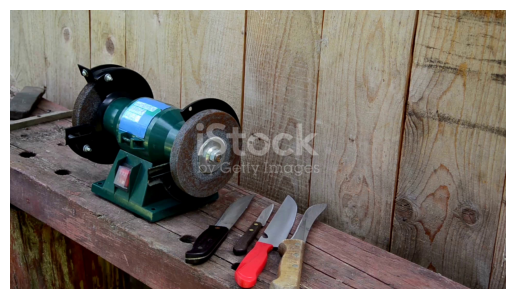

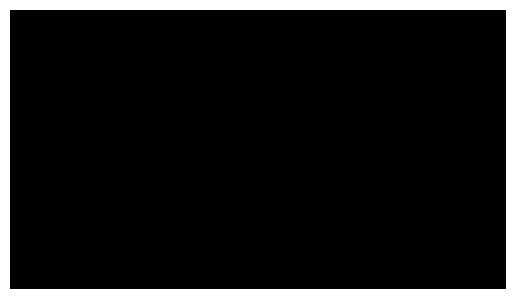

In [21]:
def read_and_filter_video(video_path, similarity_threshold=0.05):
    cap = cv2.VideoCapture(video_path)
    print(f"Total frames: {int(cap.get(cv2.CAP_PROP_FRAME_COUNT))}")

    previous_frame = None
    filtered_frames = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        if previous_frame is None:
            filtered_frames.append(frame)
        else:
            # Calcula a diferença entre o frame atual e o anterior
            diff = cv2.absdiff(previous_frame, frame)
            non_zero_count = np.count_nonzero(diff)
            total_pixels = diff.size
            similarity = 1 - (non_zero_count / total_pixels)

            # Armazena o frame se ele for significativamente diferente
            if similarity < similarity_threshold:
                filtered_frames.append(frame)

        previous_frame = frame

    cap.release()
    print(f"Distinct frames: {len(filtered_frames)}")
    for frame in filtered_frames:
      show_frame(base64.b64encode(cv2.imencode(".jpg", frame)[1]).decode())
    return filtered_frames


# Exemplo de uso
video_path = "/content/drive/MyDrive/fase05/video.mp4"
filtered_frames = read_and_filter_video(video_path)

## Detecção de Objetos Cortantes

Has Sharp Objects: True
Detection Description: Multiple images contain knives used for cutting and preparing food.


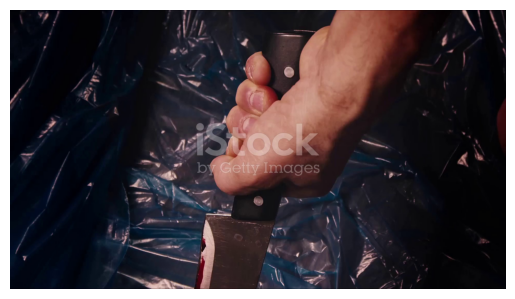

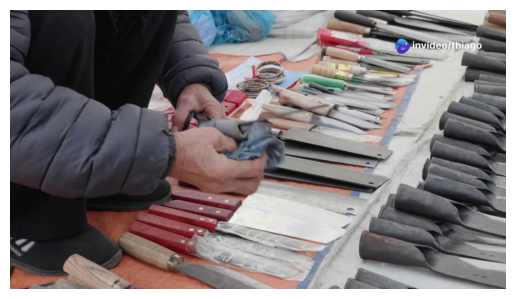

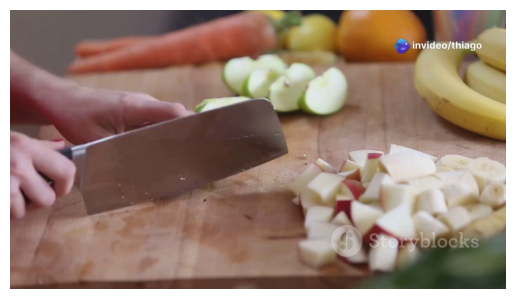

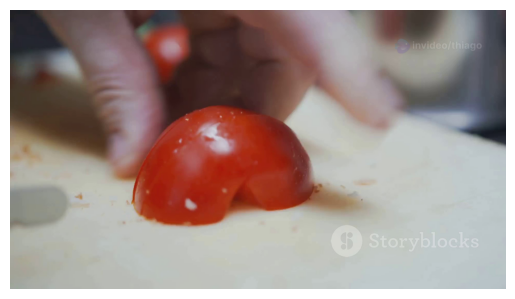

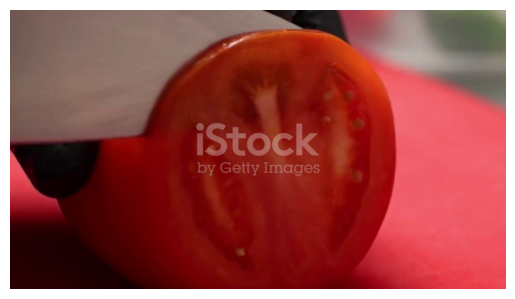

In [22]:
# Função para detectar objetos cortantes
def detect_sharp_objects(frames, batch_size=5):
    # Implementação da detecção de objetos cortantes
    base64_frames = [
        base64.b64encode(cv2.imencode(".jpg", frame)[1]).decode() for frame in frames
    ]

    # Processar os frames de N em N até encontrar objetos cortantes em algum deles
    for i in range(0, len(base64_frames), batch_size):
        batch = base64_frames[i : i + batch_size]
        messages = [
            {
                "role": "system",
                "content": """
                    Detect sharp objects in these frames and return only one JSON response with the following structure:
                    {
                        "has_sharp_objects": true | false,
                        "short_description": "A short description of the detection"
                    }
                """.strip(),
            },
            {
                "role": "user",
                "content": [
                    *map(
                        lambda x: {
                            "type": "image_url",
                            "image_url": {
                                "url": f"data:image/jpeg;base64,{x}",
                                "detail": "low",
                            },
                        },
                        batch,
                    )
                ],
            },
        ]
        params = {
            "model": "gpt-4o-mini",
            "messages": messages,
            "temperature": 0.5,
            "max_completion_tokens": 300,
            "response_format": {"type": "json_object"},
        }

        result = client.chat.completions.create(**params)
        json_content = json.loads(result.choices[0].message.content)
        if json_content["has_sharp_objects"]:
            json_content["frames"] = batch
            return json_content

    return {
        "has_sharp_objects": False,
        "short_description": "No sharp objects detected.",
    }


# Exemplo de uso
sharp_objects_response = detect_sharp_objects(filtered_frames)
print(f"Has Sharp Objects: {sharp_objects_response['has_sharp_objects']}")
print(f"Detection Description: {sharp_objects_response['short_description']}")
if sharp_objects_response["frames"]:
    for frame in sharp_objects_response["frames"]:
        show_frame(frame)

In [20]:
def send_email(subject, body, attachments=[]):
    msg = MIMEMultipart()
    msg["Subject"], msg["From"], msg["To"] = subject, EMAIL_SENDER, EMAIL_RECEIVER
    msg.attach(MIMEText(body, "plain"))

    files = [f"/tmp/frame_{i}.jpg" for i in range(len(attachments))]
    for path, data in zip(files, attachments):
        with open(path, "wb") as f:
            f.write(base64.b64decode(data))
        with open(path, "rb") as f:
            part = MIMEBase("application", "octet-stream")
            part.set_payload(f.read())
        encoders.encode_base64(part)
        part.add_header(
            "Content-Disposition", f"attachment; filename={os.path.basename(path)}"
        )
        msg.attach(part)

    try:
        with smtplib.SMTP_SSL(SMTP_SERVER, SMTP_PORT) as server:
            server.login(EMAIL_SENDER, EMAIL_PASSWORD)
            server.sendmail(EMAIL_SENDER, EMAIL_RECEIVER, msg.as_string())
        print("📩 E-mail enviado com sucesso!")
        return True
    except Exception as e:
        print(f"Erro ao enviar e-mail: {e}")
        return False
    finally:
        for path in files:
            os.remove(path)

if sharp_objects_response['has_sharp_objects']:
    send_email(
        f"Sharp Objects Detection - {video_path}",
        sharp_objects_response["short_description"],
        sharp_objects_response.get("frames", []),
    )


📩 E-mail enviado com sucesso!
